# Applied Machine Learning 

## Homework 7: Clustering and recommender systems



In [24]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.model_selection import GridSearchCV, train_test_split
from yellowbrick.cluster import KElbowVisualizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score

pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

<br><br><br><br>

## Exercise 1: Document clustering toy example <a name="1"></a>
<hr>

In lecture 14, we looked at a popular application of clustering: customer segmentation. In this homework, we will work on a toy example of another popular application: [**document clustering**](https://en.wikipedia.org/wiki/Document_clustering). A large amount of unlabeled text data is available out there (e.g., news, recipes, online Q&A), and clustering is a commonly used technique to organize this data in a meaningful way. 

In this exercise, we will create a toy dataset with sentences from Wikipedia articles and cluster these sentences. 

### 1.1 Sample sentences from Wikipedia articles
rubric={points:2}

The code below extracts first sentences of Wikipedia articles on a set of queries. You will need the `wikipedia` package installed in the course environment to run the code below. 

```
conda activate cpsc330
conda install -c conda-forge wikipedia
```

You also need `nltk` library in the course environment. 

```
conda install -c anaconda nltk 
```        

**Your tasks:**

Run the code below and answer the following question. 

1. Given this dataset, how many clusters would you expect a clustering algorithm to identify? How would you manually label these clusters?   

> *Note 2: Feel free to experiment with queries of your choice. But stick to the provided list for the final submission so that it's easier for the TAs when they grade your submission.*


In [2]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import wikipedia

queries = [
    "mango_fruit",
    "pastry",
    "Julia language",
    "Python language",
    "hockey",
    "football",
    "supervised learning",
    "unsupervised learning"    
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    sent = sent_tokenize(wikipedia.page(queries[i]).content)[0]
    wiki_dict["text"].append(sent)
    wiki_dict["n_words"].append(len(word_tokenize(sent)))
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

,wiki query,text,n_words
0,mango_fruit,A mango is an edible stone fruit produced by the tropical tree Mangifera indica.,15
1,pastry,"Pastry is baked food made with a dough of flour, water and shortening (solid fats, including butter or lard) that may be savoury or sweetened.",30
2,Julia language,"Julia is a high-level, general-purpose dynamic programming language.",10
3,Python language,"Python is a high-level, general-purpose programming language.",9
4,hockey,"Hockey is a term used to denote a family of various types of both summer and winter team sports which originated on either an outdoor field, sheet of ice, or dry floor such as in a gymnasium.",40
5,football,"Football is a family of team sports that involve, to varying degrees, kicking a ball to score a goal.",22
6,supervised learning,"Supervised learning (SL) is a machine learning paradigm for problems where the available data consists of labeled examples, meaning that each data point contains features (covariates) and an associated label.",36
7,unsupervised learning,"Supervised learning (SL) is a machine learning paradigm for problems where the available data consists of labeled examples, meaning that each data point contains features (covariates) and an associated label.",36


<br><br>

### 1.2 `KMeans` with bag-of-words representation 
rubric={points:4}

We have seen that before we pass text to machine learning models, we need to encode it into a numeric representation. So let's encode our toy dataset above (`wiki_df`) to a numeric representation. 

First, let's try our good old friend: bag-of-words representation. The code below creates dense bag-of-words representation of Wikipedia sentences from 1.1 with [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). 

**Your tasks:**

Run the code below and answer the following questions. 

1. Run `KMeans` clustering on the transformed data (`bow_sents`) with K = the number of clusters you identified in 1.1.  
2. Examine clustering labels assigned by `KMeans`. Is `KMeans` doing a reasonable job in clustering the sentences? 

> You can access cluster label assignments using `labels_` attribute of the clustering object. 

In [4]:
vec = CountVectorizer(stop_words='english')
bow_sents = vec.fit_transform(wiki_df["text"]).todense()
bow_df = pd.DataFrame(
    data=bow_sents, columns=vec.get_feature_names(), index=wiki_df.index
)
bow_df

C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,associated,available,baked,ball,butter,consists,contains,covariates,data,degrees,...,team,term,tree,tropical,types,used,various,varying,water,winter
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,0,0,1
5,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
6,1,1,0,0,0,1,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,1,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0


<br><br>

### 1.3 Sentence embedding representation
rubric={points:6}

Clustering is sensitive to what kind of representation we use for the given data. 
Bag-of-words representation is limited in that it does not take into account word ordering and context. There are other richer representations of text, and we are going to use one such representation in this exercise. 

The code below creates an alternative and a more expressive representation of sentences. We will call it *sentence embedding representation*. We'll use [sentence transformer](https://www.sbert.net/index.html) to extract these representations. At this point it's enough to know that this is an alternative representation of text which usually works better than simple bag-of-words representation. We will talk a bit more about embedding representations next week. You need to install `sentence-transformers` in the course conda environment to run the code below. 

```
conda activate cpsc330
conda install -c conda-forge sentence-transformers
```

**Your tasks:**

Run the code below and answer the following questions. 

1. How many dimensions (features associated with each example) are present in this representation? 
2. Run `KMeans` clustering with sentence embedding representation of text (`emb_sents`) and examine cluster labels. 
3. How well the sentences are clustered together? 

In [5]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

In [6]:
emb_sents = embedder.encode(wiki_df["text"])
emb_sent_df = pd.DataFrame(emb_sents, index=wiki_df.index)
emb_sent_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.141320,0.030475,0.261100,-0.219024,-0.277812,0.177240,0.191266,0.252725,-0.035201,0.198338,...,0.104466,-0.177959,0.088619,0.289035,-0.089657,0.246049,-0.060229,0.500508,-0.045897,-0.046336
1,-0.033798,0.080434,-0.009776,0.352398,0.461037,-0.053741,-0.130920,0.153677,-0.217347,0.285473,...,0.108543,0.049569,0.212272,0.163554,0.084531,0.355887,-0.026408,0.262068,0.066258,-0.113360
2,0.038495,0.232494,0.145228,0.171133,0.595674,0.004730,0.015232,0.190611,0.200516,0.277641,...,0.422849,-0.000556,0.239732,0.223418,0.457427,0.183333,0.345800,-0.017926,-0.073692,-0.181234
3,0.101454,0.046039,0.127588,-0.036343,0.478972,0.132067,-0.035592,0.390519,0.188473,0.348842,...,0.321178,0.367853,0.154809,0.116112,0.101856,0.278487,0.233325,0.111571,0.009258,-0.154423
4,-0.071380,0.096587,0.055705,-0.525645,0.580350,0.096592,0.441485,0.257062,-0.054260,0.220842,...,0.457613,-0.331446,-0.066380,-0.019426,-0.147649,0.034530,-0.095109,0.304423,0.327636,-0.197770
5,-0.071756,0.133156,-0.071762,0.306060,0.358961,-0.061443,0.167585,0.364614,0.323540,0.141398,...,0.404115,0.000236,0.177493,0.016162,0.232335,0.260556,0.168149,0.483963,0.121122,0.196881
6,0.132971,-0.147192,-0.016004,0.322425,0.715167,0.283975,0.211146,0.183430,0.208825,0.195129,...,-0.112675,0.154009,0.031885,0.144829,-0.239938,-0.028377,0.208579,-0.352403,0.158447,-0.020454
7,0.132971,-0.147192,-0.016004,0.322425,0.715167,0.283975,0.211146,0.183430,0.208825,0.195129,...,-0.112675,0.154009,0.031885,0.144829,-0.239938,-0.028377,0.208579,-0.352403,0.158447,-0.020454


<br><br>

### 1.4 DBSCAN with cosine distance  
rubric={points:8}

Let's try `DBSCAN` on our toy dataset. K-Means is kind of bound to the Euclidean distance because it is based on the notion of means. With `DBSCAN` we can try different distance metrics. In the context of text (sparse data), [cosine similarities](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) or cosine distances tend to work better. Given vectors $u$ and $v$, the **cosine distance** between the vectors is defined as: 

$$distance_{cosine}(u,v) = 1 - (\frac{u \cdot v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2})$$

In this exercise, you'll use DBSCAN with cosine distances. 

**Your tasks**

1. Use DBSCAN to cluster our toy data using sentence embedding representation (`emb_sents`) and `metric='cosine'`. 
2. Briefly comment on the number of clusters identified and the cluster assignment given by the algorithm.

> *Note: You will also have to set appropriate values for the hyperparamters `eps` and `min_samples` to get meaningful clusters, as default values for these hyperparameters won't work on this toy dataset. In order to set appropriate value for `eps`, you may want to examine the distances given by [sklearn's `cosine_distance`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html).*

In [7]:
nei = NearestNeighbors(n_neighbors=2)
nebs = nei.fit(emb_sent_df)
distance, idx = nebs.kneighbors(emb_sent_df)

In [8]:
distance = np.sort(distance, axis = 0)
distances = distance[:,1]

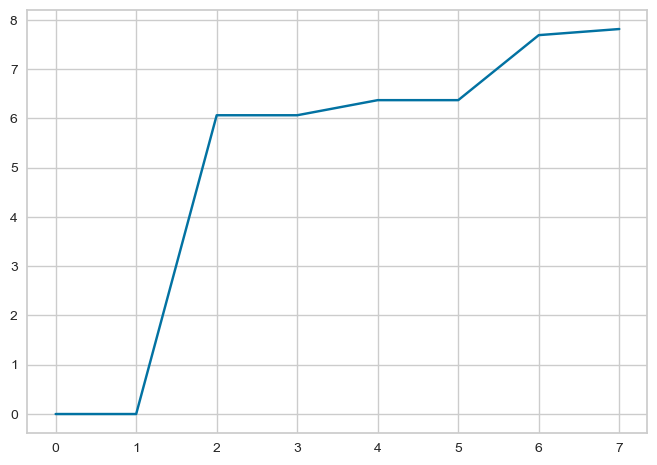

In [9]:
plt.plot(distances);

In [10]:
sample = np.arange(3,9,1)
for i in sample:
    model = DBSCAN(metric = 'cosine', eps=6, min_samples=i).fit(emb_sent_df)
    labels = model.labels_
    #sil_sc = silhouette_score(emb_sent_df, labels)
    print(f'{i} sillhoueta score = {labels}')

3 sillhoueta score = [0 0 0 0 0 0 0 0]
4 sillhoueta score = [0 0 0 0 0 0 0 0]
5 sillhoueta score = [0 0 0 0 0 0 0 0]
6 sillhoueta score = [0 0 0 0 0 0 0 0]
7 sillhoueta score = [0 0 0 0 0 0 0 0]
8 sillhoueta score = [0 0 0 0 0 0 0 0]


<br><br>

### 1.5 Visualizing clusters 
rubric={points:5}

One thing we could do with unlabeled data is visualizing it. That said, our data is high dimensional (each example is represented with 768 dimensions) and high-dimensional data is hard to visualize. One way to visualize high-dimensional data is applying dimensionality reduction to get the most important (2 or 3) components of the dataset and visualizing this low-dimensional data. 

Given data as a `numpy` array and cluster assignments, the `plot_pca_clusters` function below transforms the given data by applying dimensionality reduction and plots the transformed data into corresponding clusters. 

> *Note: At this point we are using this function only for visualization and you are not expected to understand the PCA part. Feel free to modify the function as you see fit.*

**Your tasks:**

1. Call the function `plot_pca_clusters` to visualize the clusters created by the three models above:
    - KMeans with bag-of-words representation 
    - KMeans with sentence embedding representation 
    - DBSCAN with sentence embedding representation 

In [11]:
models = {
    'dbscan': DBSCAN(metric = 'cosine'),
    'knn': KMeans() with bagOfWords
    'knn': ??? with sentence embedding
}

SyntaxError: invalid syntax (2634045993.py, line 3)

In [ ]:
from sklearn.decomposition import PCA # Obtain the principal components

def plot_pca_clusters(
    data,
    cluster_labels,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=100,
    title="PCA visualization",
):
    """
    Carry out dimensionality reduction using PCA and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principal_comp, columns=["pca1", "pca2"])
    pca_df["cluster"] = cluster_labels

    plt.figure(figsize=(10, 7))
    plt.title(title)
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10", s=size
    )

    x = pca_df["pca1"].tolist()
    y = pca_df["pca2"].tolist()
    if show_labels:
        for i, txt in enumerate(raw_sents):
            plt.annotate(" ".join(txt.split()[:10]), (x[i], y[i]))
        ax.legend(loc="upper right")

    plt.show()

In [ ]:
plot_pca_clusters(data = emb_send_df, cluster_labels=)

<br><br><br><br>

## Exercise 2: Movie recommendations
<hr>

Let's build simple movie recommendation systems using the [MovieLens dataset](https://www.kaggle.com/prajitdatta/movielens-100k-dataset/data). The original source of the data is [here](https://grouplens.org/datasets/movielens/), and the structure of the data is described in the [README](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) that comes with it. The code below reads the data as a CSV assuming that it's under `data/ml-100k/` directory under your lab folder. 

In [93]:
r_cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(
    os.path.join("data", "ml-100k","ml-100k", "u.data"),
    sep="\t",
    names=r_cols,
#     nrows = 10000,
    encoding="latin-1",
)
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [94]:
# We'll be using these keys later in the starter code
user_key = "user_id"
item_key = "movie_id"

### 2.1 Terminology
rubric={points:3}

Here is some notation we will be using in this homework. 

**Constants**:

 - $N$: the number of users, indexed by $n$
 - $M$: the number of movies, indexed by $m$
 - $\mathcal{R}$: the set of indices $(n,m)$ where we have ratings in the utility matrix $Y$
    - Thus $|\mathcal{R}|$ is the total number of ratings
 
**The data**:

 - $Y$: the utility matrix containing ratings, with a lot of missing entries
 - `train_mat` and `valid_mat`: Utility matrices for train and validation sets, respectively
 
    
**Your tasks:**    

1. What are the values of $N$ and $M$ in movie ratings data?  
2. What would be the shape of the dense utility matrix $Y$? 
3. What would be the fraction of non missing ratings in the utility matrix $Y$? 

In [95]:
N = len(np.unique(ratings["user_id"]))
M = len(np.unique(ratings["movie_id"]))
print("Number of users (N) : %d" % N)
print("Number of movies (M) : %d" % M)

Number of users (N) : 943
Number of movies (M) : 1682


<br><br>

### 2.2 Splitting the data
rubric={points:5}

**Your tasks:**

1. Split the ratings data with `test_size=0.2` and `random_state=42`. 

In [96]:
x = ratings[["user_id", "movie_id"]]
y = ratings["rating"]

X_train, y_train, X_test, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

In [97]:
X_train

,user_id,movie_id
75220,807,1411
48955,474,659
44966,463,268
13568,139,286
92727,621,751
...,...,...
6265,216,231
54886,343,276
76820,437,475
860,284,322


<br><br>

### 2.3 Utility matrix 
rubric={points:10}

**Your tasks**
1. Create utility matrices for train and validation sets (similar to how we did in the class). 
2. Briefly explain the difference between the train and validation utility matrices. 

> You may use the code from lecture notes with appropriate attributions.  

> You won't do it in real life but since our dataset is not that big, create a dense utility matrix in this assignment. You are welcome to try sparse matrix but then you may have to change some started code provided in the later exercises.  

In [98]:
user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(ratings[item_key])))

In [99]:
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y

In [103]:
Y = create_Y_from_ratings(ratings, N, M)
train_mat = pd.DataFrame(Y, columns=item_mapper.keys(), index=user_mapper.keys())
valid_mat= pd.DataFrame(Y, columns=item_mapper.keys(), index=user_mapper.keys())

In [114]:
from sklearn.decomposition import TruncatedSVD

k = 1
algo = TruncatedSVD(n_components=k, random_state=42)
algo.fit(X_train)
preds = algo.test(X_train.build_testset())
# preds

AttributeError: 'TruncatedSVD' object has no attribute 'test'

<br><br>

### 2.4 Evaluation and baseline
rubric={points:4}

To compare different models you build in this homework, let's write a couple of functions for evaluation. 
- The `error` function returns RMSE.
- The `evaluate` function prints the train and validation RMSEs. 

**Your task:**

1. Briefly explain what exactly we are comparing to evaluate recommender systems. 
2. Implement the global average baseline, where you predict everything as the global average rating. What's the RMSE of the global average baseline?

In [ ]:
def error(Y1, Y2):
    """
    Returns the root mean squared error (RMSE).
    """
    return np.sqrt(np.nanmean((Y1 - Y2) ** 2))


def evaluate(pred_Y, train_mat, valid_mat, model_name="Global average"):
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat)))

<br><br>

### (Optional) 2.5 $k$-nearest neighbours imputation
rubric={points:1}

**Your tasks:**

Try [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) to fill in the missing entries. Discuss your observations. 

<br><br>

### 2.6 Use collaborative filtering with the `surprise` package
rubric={points:6}

Use the [`surprise`](https://surprise.readthedocs.io/en/stable/) package which has implementation of SVD algorithm for collaborative filtering. You can install it as follows in your conda environment. 

```
>> conda activate cpsc330
>> conda install -c conda-forge scikit-surprise
or 
>> pip install scikit-surprise
```

**Your tasks:**

1. Carry out cross-validation using SVD algorithm in the package, similar to how we did it in the lecture on Jester dataset. Report mean RMSE and compare it with global baseline. 

<br><br><br><br>

## Exercise 3: Short answer questions
<hr>

rubric={points:5}

Answer the following short-answer questions: 

1. What's the main difference between unsupervised and supervised learning?
2. When choosing $k$ in K-Means, why not just choose the $k$ that leads to the smallest inertia (sum of squared distances within clusters)?
3. You decide to use clustering for _outlier detection_; that is, to detect instances that are very atypical compared to all the rest. How might you do this with $k$-means?
4. You decide to use clustering for _outlier detection_; that is, to detect instances that are very atypical compared to all the rest. How might you do this with DBSCAN?
5. How might you apply clustering to recommendation systems? 

<br><br><br><br>